In [15]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

In [4]:
trash = pd.read_csv('trash_hauler_report.csv')
trash.head()

,Request Number,Date Opened,Request,Description,Incident Address,Zip Code,Trash Hauler,Trash Route,Council District,State Plan X,State Plan Y
0,25270,11/01/17,Trash - Backdoor,"house with the wheel chair ramp, they share dr...",3817 Crouch Dr,37207.0,RED RIVER,3205,2.0,1.727970e+06,686779.478089
1,25274,11/01/17,Trash - Curbside/Alley Missed Pickup,Curb/Trash miss Tuesday.,4028 Clarksville Pike,37218.0,RED RIVER,4202,1.0,1.721259e+06,685444.799565
2,25276,11/01/17,Trash - Curbside/Alley Missed Pickup,Curb/trash miss Tuesday.,6528 Thunderbird Dr,37209.0,RED RIVER,4205,20.0,1.707027e+06,659887.471571
3,25307,11/01/17,Trash - Curbside/Alley Missed Pickup,missed,2603 old matthews rd,37207.0,WASTE IND,2206,2.0,1.735692e+06,685027.245923
4,25312,11/01/17,Trash - Curbside/Alley Missed Pickup,Missed the even side of the road.,604 croley dr,37209.0,RED RIVER,4203,20.0,1.710186e+06,664205.101066


In [5]:
trash.columns = trash.columns.str.strip()
trash['Zip Code'] = trash['Zip Code'].astype('Int64').astype(str).str.zfill(5)
trash = trash[trash['Request'] != 'Damage to Property']

missed_categories = ['Trash - Backdoor', 'Trash - Curbside/Alley Missed Pickup']

pattern = r"\bmiss\w*\b|not\s+emptied|not\s+picked\s+up|no\s+pick\s+up" #miss/missed, not emptied, not picked up, no pick up

if isinstance(missed_categories, list):
    missed_pattern = '|'.join(missed_categories)
else:
    missed_pattern = missed_categories 

rrmissed = trash[
    (trash['Trash Hauler'].str.contains("Red River", case=False, na=False)) &
    (
        (trash['Request'].str.contains(missed_pattern, case=False, na=False)) |
        (trash['Description'].str.contains(pattern, case=False, na=False))
    )
]

rrmissed = rrmissed.dropna(subset = ['Incident Address']) # drop known missing address

# rrmissed = rrmissed.drop_duplicates(subset=['Incident Address', 'Date Opened']) # I believe this is redundancy and is taken care of later

def normalize_address(s: str) -> str:
    if pd.isna(s):
        return s
    # Only keep everything before the first comma
    s = s.split(",")[0]
    s = s.upper()
    s = re.sub(r"[.,]", " ", s)
    s = re.sub(r"\s+", " ", s).strip()
    # (keep the direction/street type replacements here)
    return s

rrmissed["address_norm"] = rrmissed["Incident Address"].apply(normalize_address)

rrmissed["Date Opened"] = pd.to_datetime(rrmissed["Date Opened"], errors="coerce")
rrmissed["date_only"] = rrmissed["Date Opened"].dt.date

rrmissed_dedup = (
    rrmissed.sort_values(['address_norm', 'date_only', 'Date Opened'])
    .drop_duplicates(subset=['address_norm', 'date_only'], keep='first')
    .reset_index(drop=True)
)

gap = rrmissed_dedup.groupby("address_norm")["Date Opened"].diff().dt.days
rrmissed_dedup["new_event"] = (gap.isna()) | (gap > 6)
rrmissed_dedup["event_id"]  = rrmissed_dedup.groupby("address_norm")["new_event"].cumsum()

grp = rrmissed_dedup.groupby(['address_norm', "event_id"])['Date Opened']
rrmissed_dedup["event_date"]     = grp.transform("min")     

rrmissed_dedup["event_seq"] = rrmissed_dedup["event_id"].astype("Int64")

rrmissed_dedup["fine_event"] = (rrmissed_dedup["event_seq"] > 1).astype(int) * 200

rrmissed_dedup["first_event"] = (rrmissed_dedup['Date Opened'] == rrmissed_dedup["event_date"])
rrmissed_dedup["fine_event"] = rrmissed_dedup["fine_event"].where(rrmissed_dedup["first_event"], 0)

C:\Users\user\AppData\Local\Temp\ipykernel_7160\2230562832.py:39: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  rrmissed["Date Opened"] = pd.to_datetime(rrmissed["Date Opened"], errors="coerce")


In [6]:
rrmissed_dedup

,Request Number,Date Opened,Request,Description,Incident Address,Zip Code,Trash Hauler,Trash Route,Council District,State Plan X,State Plan Y,address_norm,date_only,new_event,event_id,event_date,event_seq,fine_event,first_event
0,155122,2019-03-15,Trash - Curbside/Alley Missed Pickup,MISS,"100 Bluefield Square, Nashville, TN 37214, Uni...",37214,RED RIVER,1505,15.0,1.770431e+06,666861.601362,100 BLUEFIELD SQUARE,2019-03-15,True,1,2019-03-15,1,0,True
1,52252,2018-03-07,Trash - Curbside/Alley Missed Pickup,Missed- trash,100 Braxton Hill Ct,37204,RED RIVER,3302S,25.0,1.733781e+06,640909.303557,100 BRAXTON HILL CT,2018-03-07,True,1,2018-03-07,1,0,True
2,121431,2018-12-05,Trash - Curbside/Alley Missed Pickup,Missed- trash,100 Brook Hollow Rd,37205,RED RIVER,1303,23.0,1.708043e+06,642454.642918,100 BROOK HOLLOW RD,2018-12-05,True,1,2018-12-05,1,0,True
3,30424,2017-11-28,Trash - Curbside/Alley Missed Pickup,missed pick up,100 cedarmont ct,37211,RED RIVER,4403,31.0,1.760265e+06,622441.107959,100 CEDARMONT CT,2017-11-28,True,1,2017-11-28,1,0,True
4,142247,2019-02-14,Trash - Curbside/Alley Missed Pickup,Trash was not collected from any customers on ...,"100 Clydelan Ct, Nashville, TN 37205, United S...",37205,RED RIVER,1302,34.0,1.710255e+06,640390.616149,100 CLYDELAN CT,2019-02-14,True,1,2019-02-14,1,0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13125,192335,2019-05-31,Trash - Curbside/Alley Missed Pickup,odd # side of street was not picked up.,"Old Tusculum Rd, Antioch, Tennessee, 37013",37013,RED RIVER,4404,30.0,1.763332e+06,626852.263728,OLD TUSCULUM RD,2019-05-31,True,1,2019-05-31,1,0,True
13126,133573,2019-01-23,Trash - Curbside/Alley Missed Pickup,got only one side of street,"Queens Ln, Nashville, TN 37218, United States",37218,RED RIVER,3203,1.0,1.714591e+06,686127.550777,QUEENS LN,2019-01-23,True,1,2019-01-23,1,0,True
13127,25809,2017-11-02,Trash - Curbside/Alley Missed Pickup,Robin Springs Road missed!,Robin Springs Rd,37220,RED RIVER,3302S,34.0,1.732450e+06,639784.397978,ROBIN SPRINGS RD,2017-11-02,True,1,2017-11-02,1,0,True
13128,256189,2019-10-07,Trash - Curbside/Alley Missed Pickup,this street missed,"Trevino Pl, Nashville, TN 37013, United States",37013,RED RIVER,3505,29.0,1.785940e+06,636624.255256,TREVINO PL,2019-10-07,True,1,2019-10-07,1,0,True


In [7]:
rrmissed_final = rrmissed_dedup[rrmissed_dedup['new_event'] == True]

In [8]:
rrmissed_final

,Request Number,Date Opened,Request,Description,Incident Address,Zip Code,Trash Hauler,Trash Route,Council District,State Plan X,State Plan Y,address_norm,date_only,new_event,event_id,event_date,event_seq,fine_event,first_event
0,155122,2019-03-15,Trash - Curbside/Alley Missed Pickup,MISS,"100 Bluefield Square, Nashville, TN 37214, Uni...",37214,RED RIVER,1505,15.0,1.770431e+06,666861.601362,100 BLUEFIELD SQUARE,2019-03-15,True,1,2019-03-15,1,0,True
1,52252,2018-03-07,Trash - Curbside/Alley Missed Pickup,Missed- trash,100 Braxton Hill Ct,37204,RED RIVER,3302S,25.0,1.733781e+06,640909.303557,100 BRAXTON HILL CT,2018-03-07,True,1,2018-03-07,1,0,True
2,121431,2018-12-05,Trash - Curbside/Alley Missed Pickup,Missed- trash,100 Brook Hollow Rd,37205,RED RIVER,1303,23.0,1.708043e+06,642454.642918,100 BROOK HOLLOW RD,2018-12-05,True,1,2018-12-05,1,0,True
3,30424,2017-11-28,Trash - Curbside/Alley Missed Pickup,missed pick up,100 cedarmont ct,37211,RED RIVER,4403,31.0,1.760265e+06,622441.107959,100 CEDARMONT CT,2017-11-28,True,1,2017-11-28,1,0,True
4,142247,2019-02-14,Trash - Curbside/Alley Missed Pickup,Trash was not collected from any customers on ...,"100 Clydelan Ct, Nashville, TN 37205, United S...",37205,RED RIVER,1302,34.0,1.710255e+06,640390.616149,100 CLYDELAN CT,2019-02-14,True,1,2019-02-14,1,0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13125,192335,2019-05-31,Trash - Curbside/Alley Missed Pickup,odd # side of street was not picked up.,"Old Tusculum Rd, Antioch, Tennessee, 37013",37013,RED RIVER,4404,30.0,1.763332e+06,626852.263728,OLD TUSCULUM RD,2019-05-31,True,1,2019-05-31,1,0,True
13126,133573,2019-01-23,Trash - Curbside/Alley Missed Pickup,got only one side of street,"Queens Ln, Nashville, TN 37218, United States",37218,RED RIVER,3203,1.0,1.714591e+06,686127.550777,QUEENS LN,2019-01-23,True,1,2019-01-23,1,0,True
13127,25809,2017-11-02,Trash - Curbside/Alley Missed Pickup,Robin Springs Road missed!,Robin Springs Rd,37220,RED RIVER,3302S,34.0,1.732450e+06,639784.397978,ROBIN SPRINGS RD,2017-11-02,True,1,2017-11-02,1,0,True
13128,256189,2019-10-07,Trash - Curbside/Alley Missed Pickup,this street missed,"Trevino Pl, Nashville, TN 37013, United States",37013,RED RIVER,3505,29.0,1.785940e+06,636624.255256,TREVINO PL,2019-10-07,True,1,2019-10-07,1,0,True


In [9]:
total_fines = int(rrmissed_final["fine_event"].sum())
unique_events = int(
    rrmissed_final[rrmissed_final['event_id'] != 1].drop_duplicates(['address_norm', "event_id"]).shape[0]
)

In [10]:
total_fines

827400

In [11]:
unique_events

4137

In [207]:
rrmissed_final.to_csv('rrmissed_final.csv', index = False)

In [34]:
rrmissed_final_fined = rrmissed_final[rrmissed_final['fine_event'] != 0]

In [35]:
rrmissed_final_fined

,Request Number,Date Opened,Request,Description,Incident Address,Zip Code,Trash Hauler,Trash Route,Council District,State Plan X,State Plan Y,address_norm,date_only,new_event,event_id,event_date,event_seq,fine_event,first_event
11,219376,2019-07-23,Trash - Curbside/Alley Missed Pickup,continuous misses,"100 Nashboro Greens, Nashville, TN 37217, Unit...",37217,RED RIVER,2505,29.0,1.778871e+06,640860.298135,100 NASHBORO GREENS,2019-07-23,True,2,2019-07-23,2,200,True
15,216148,2019-07-17,Trash - Curbside/Alley Missed Pickup,Curb trash/missed Tuesday Dead end street. Che...,"100 Rhine Dr, Nashville, TN 37115, United States",37115,RED RIVER,3212,8.0,1.750466e+06,703800.798806,100 RHINE DR,2019-07-17,True,2,2019-07-17,2,200,True
17,256932,2019-10-09,Trash - Curbside/Alley Missed Pickup,missed trash,"100 S GRAYCROFT AVE, 37115",37115,RED RIVER,3214,8.0,1.752490e+06,703450.683280,100 S GRAYCROFT AVE,2019-10-09,True,2,2019-10-09,2,200,True
25,169354,2019-04-15,Trash - Curbside/Alley Missed Pickup,missed trash,"1000 Flintlock Ct, Nashville, TN 37217, United...",37217,RED RIVER,2505,29.0,1.780096e+06,638311.436050,1000 FLINTLOCK CT,2019-04-15,True,2,2019-04-15,2,200,True
27,233815,2019-08-19,Trash - Curbside/Alley Missed Pickup,EVERYONE'S TRASH IS STILL OUT.,"1000 Trevino Pl, Antioch, Tennessee, 37013",37013,RED RIVER,3505,29.0,1.785843e+06,636907.168793,1000 TREVINO PL,2019-08-19,True,2,2019-08-19,2,200,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13096,126743,2018-12-31,Trash Collection Complaint,Trash/never does cart gets pickup on Wednesday...,"960 44th Ave N, Nashville, TN 37209, United St...",37209,RED RIVER,1309,20.0,1.720477e+06,666161.601824,960 44TH AVE N,2018-12-31,True,4,2018-12-31,4,200,True
13098,81230,2018-07-08,Trash - Curbside/Alley Missed Pickup,Our neighbors cans were emptied but not ours.,960 battery ln,37220,RED RIVER,3302,25.0,1.735063e+06,639880.770427,960 BATTERY LN,2018-07-08,True,2,2018-07-08,2,200,True
13104,235738,2019-08-21,Trash - Curbside/Alley Missed Pickup,miss,"971 Windrowe Dr, Nashville, TN 37205, United S...",37205,RED RIVER,1301,23.0,1.701565e+06,650680.391888,971 WINDROWE DR,2019-08-21,True,2,2019-08-21,2,200,True
13109,212542,2019-07-10,Trash - Curbside/Alley Missed Pickup,miss,"986 Malquin Dr, Nashville, TN 37216, United St...",37216,RED RIVER,2204,8.0,1.753519e+06,691299.198896,986 MALQUIN DR,2019-07-10,True,2,2019-07-10,2,200,True


In [36]:
rrmissed_final_fined.to_csv('rrmissed_final_fined.csv', index = False)

## Plotting

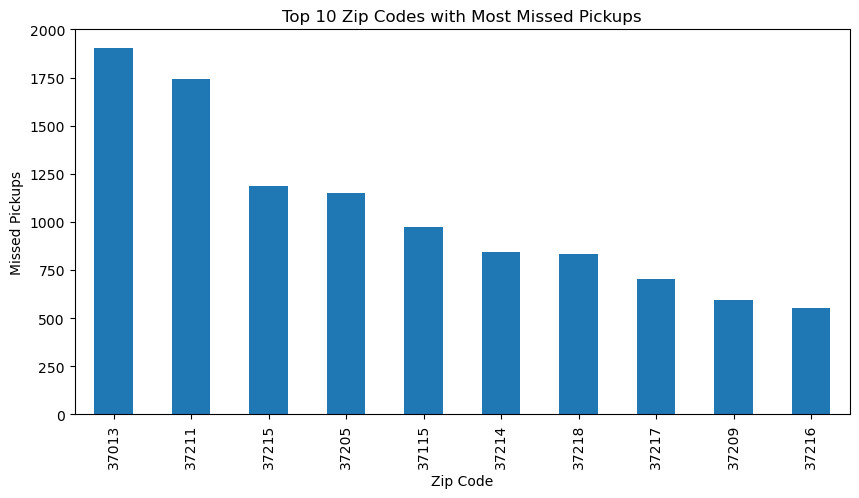

In [20]:
missed_by_zip = rrmissed_final['Zip Code'].value_counts().head(10)

missed_by_zip.plot(kind="bar", figsize=(10,5), title="Top 10 Zip Codes with Most Missed Pickups")
plt.ylabel("Missed Pickups")
plt.show()

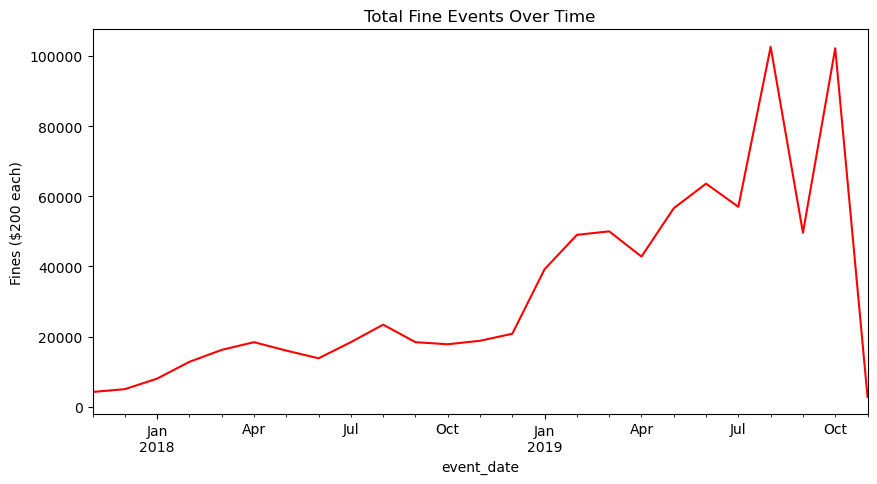

In [25]:
fines_only = rrmissed_final[rrmissed_final['fine_event'] != 0]
fine_costs = fines_only.groupby(fines_only['event_date'].dt.to_period("M"))['fine_event'].sum()

fine_costs.plot(kind="line", figsize=(10,5), title="Total Fine Events Over Time", color="red")
plt.ylabel("Fines ($200 each)")
plt.show()

In [30]:
fine_costs.head()

event_date
2017-11     4200
2017-12     5000
2018-01     8000
2018-02    12800
2018-03    16200
Freq: M, Name: fine_event, dtype: int64

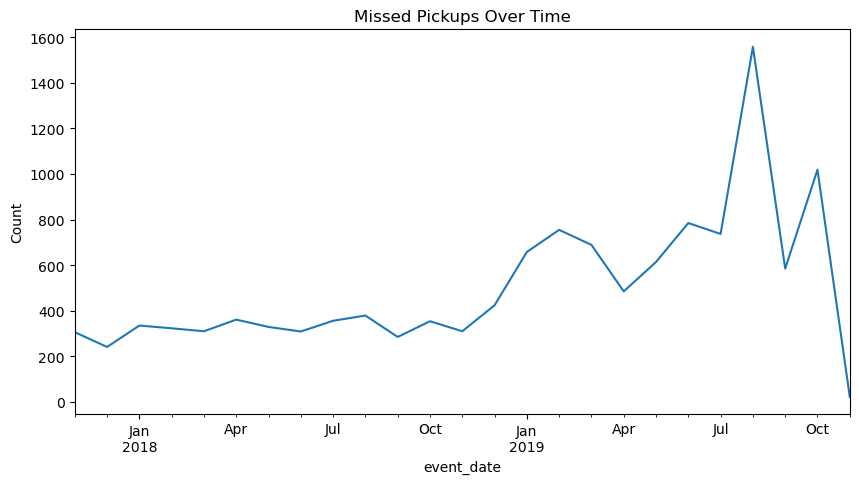

In [26]:
missed_over_time = rrmissed_final.groupby(rrmissed_final['event_date'].dt.to_period("M")).size()

missed_over_time.plot(kind="line", figsize=(10,5), title="Missed Pickups Over Time")
plt.ylabel("Count")
plt.show()

In [29]:
missed_over_time.head()

event_date
2017-11    306
2017-12    241
2018-01    335
2018-02    323
2018-03    310
Freq: M, dtype: int64